## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

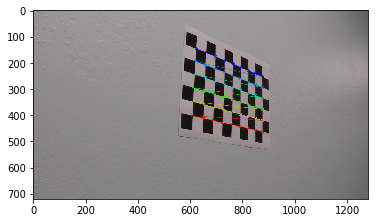

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
calib_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

### Test undistorted correction

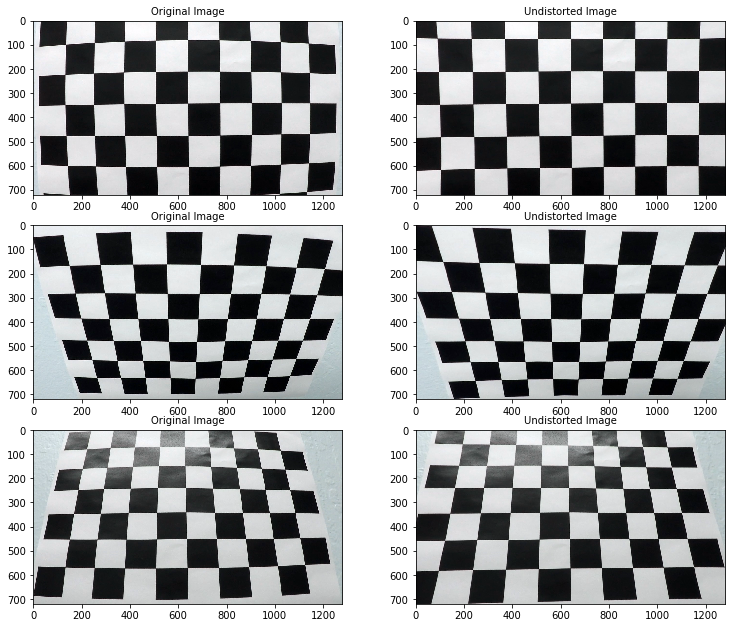

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    #undist = np.copy(img)  # Delete this line
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img1 = cv2.imread('camera_cal/calibration1.jpg')
undistorted1 = cal_undistort(img1, objpoints, imgpoints)
img2 = cv2.imread('camera_cal/calibration2.jpg')
undistorted2 = cal_undistort(img2, objpoints, imgpoints)
img3 = cv2.imread('camera_cal/calibration3.jpg')
undistorted3 = cal_undistort(img3, objpoints, imgpoints)

f, ax = plt.subplots(3, 2, figsize=(10, 9))
f.tight_layout()
ax[0,0].imshow(img1)
ax[0,0].set_title('Original Image', fontsize=10)

ax[0,1].imshow(undistorted1)
ax[0,1].set_title('Undistorted Image', fontsize=10)

ax[1,0].imshow(img2)
ax[1,0].set_title('Original Image', fontsize=10)

ax[1,1].imshow(undistorted2)
ax[1,1].set_title('Undistorted Image', fontsize=10)

ax[2,0].imshow(img3)
ax[2,0].set_title('Original Image', fontsize=10)

ax[2,1].imshow(undistorted3)
ax[2,1].set_title('Undistorted Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

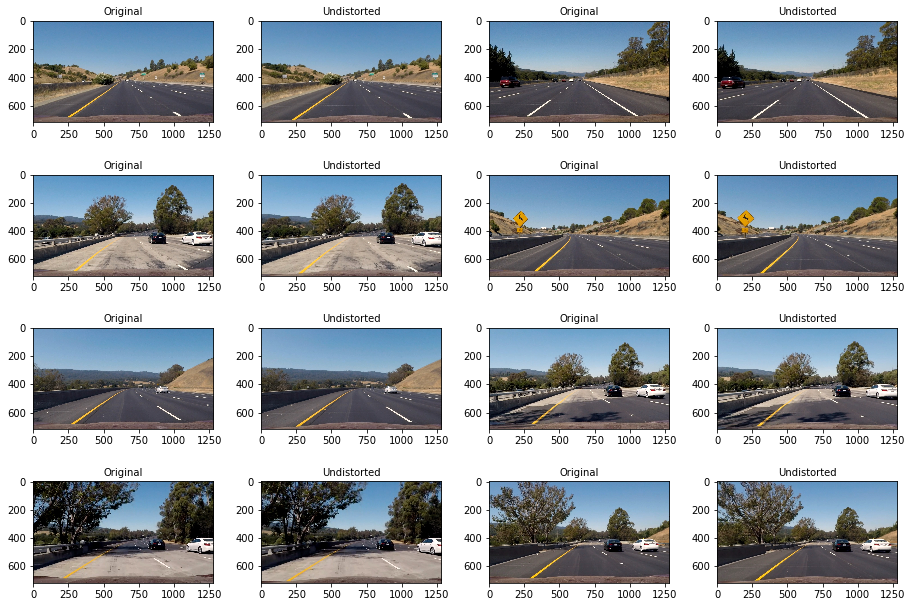

In [4]:
test_images = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(4, 4, figsize=(12, 9));
f.tight_layout()

undistorted_images = []
ax1, ax2 = 0, 0
for fname in test_images:
    img = cv2.cvtColor( cv2.imread(fname), cv2.COLOR_BGR2RGB)
    
    ax[ax1, ax2].imshow( img )
    ax[ax1, ax2].set_title('Original', fontsize=10)
    
    ax2+=1
    
    undist = cal_undistort(img, objpoints, imgpoints)
    undistorted_images.append( undist )
    ax[ax1, ax2].imshow( undist )
    ax[ax1, ax2].set_title('Undistorted', fontsize=10)
    
    if ax2==3:
        ax2=0
        ax1+=1
    else:
        ax2+=1

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.);

### Use color transforms, gradients, etc., to create a thresholded binary image.

#### Gradient treeshold

In [41]:
# Sobel Functions 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255) ):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #gray = gray[:,:,2]
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    binary_output = sxbinary#np.copy(img) # Remove this line
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #gray = gray[:,:,2]
    
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobelMag = np.sqrt(sobelX**2 + sobelY**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelMag/np.max(sobelMag))
    
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #gray = gray[:,:,2]
    
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelX = np.absolute(sobelX)
    abs_sobelY = np.absolute(sobelY)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobelY, abs_sobelX)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(dir)
    sxbinary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

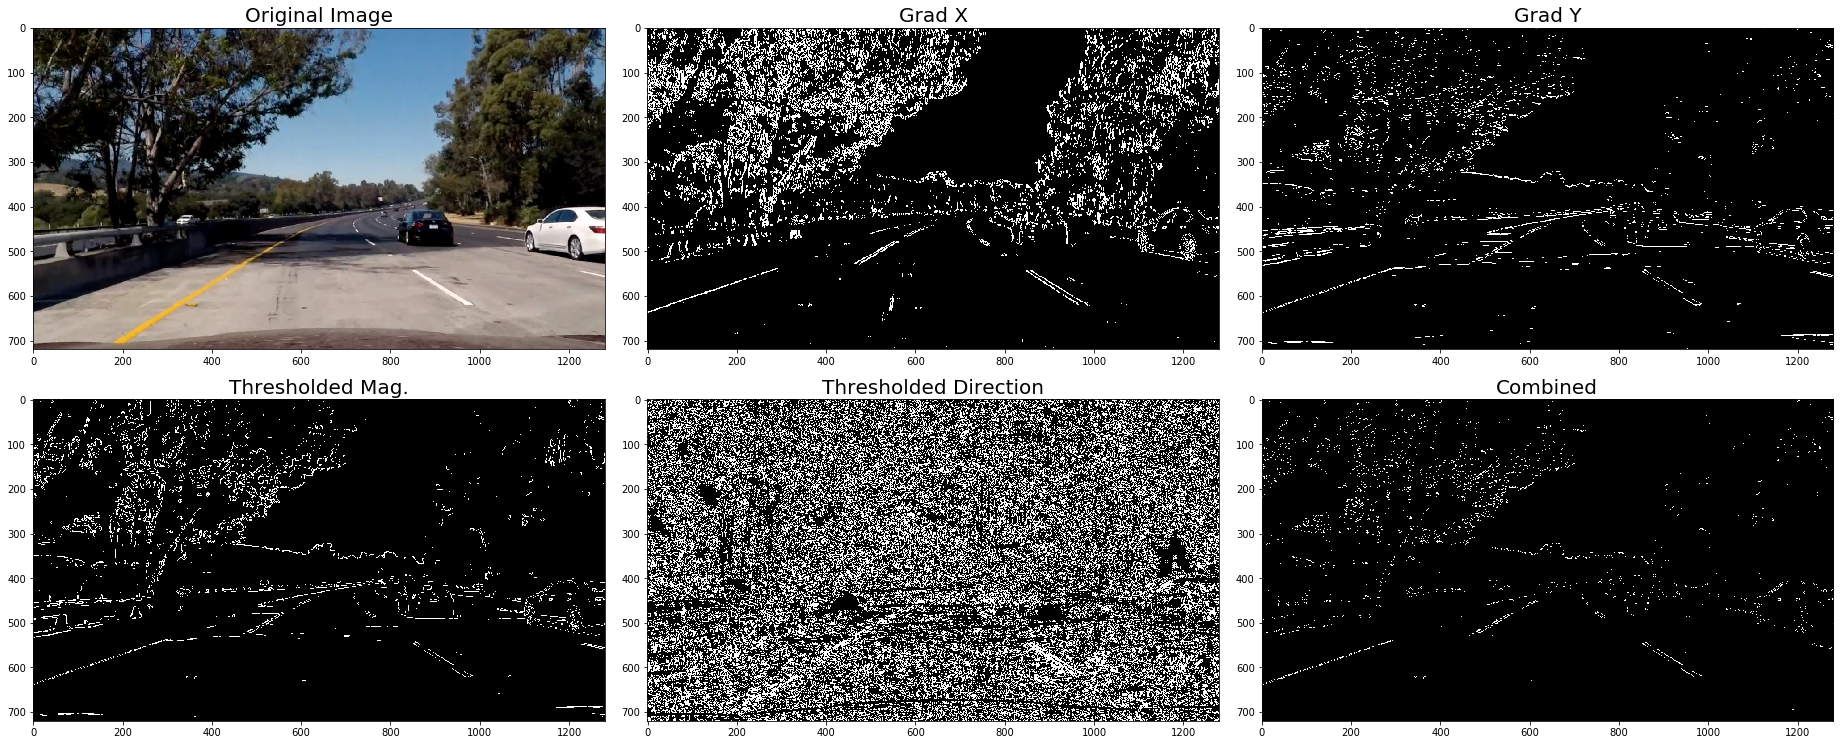

In [143]:
image = undistorted_images[6]

# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 80))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(60, 100))
#dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(.7, 1.3))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, axarr = plt.subplots(2, 3, figsize=(25, 11))
f.tight_layout()

axarr[0,0].imshow(image)
axarr[0,0].set_title('Original Image', fontsize=20)

axarr[0,1].imshow(gradx, cmap='gray')
axarr[0,1].set_title('Grad X', fontsize=20)

axarr[0,2].imshow(grady, cmap='gray')
axarr[0,2].set_title('Grad Y', fontsize=20)

axarr[1,0].imshow(mag_binary, cmap='gray')
axarr[1,0].set_title('Thresholded Mag.', fontsize=20)

axarr[1,1].imshow(dir_binary, cmap='gray')
axarr[1,1].set_title('Thresholded Direction', fontsize=20)

axarr[1,2].imshow(combined, cmap='gray')
axarr[1,2].set_title('Combined', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Color Treeshold

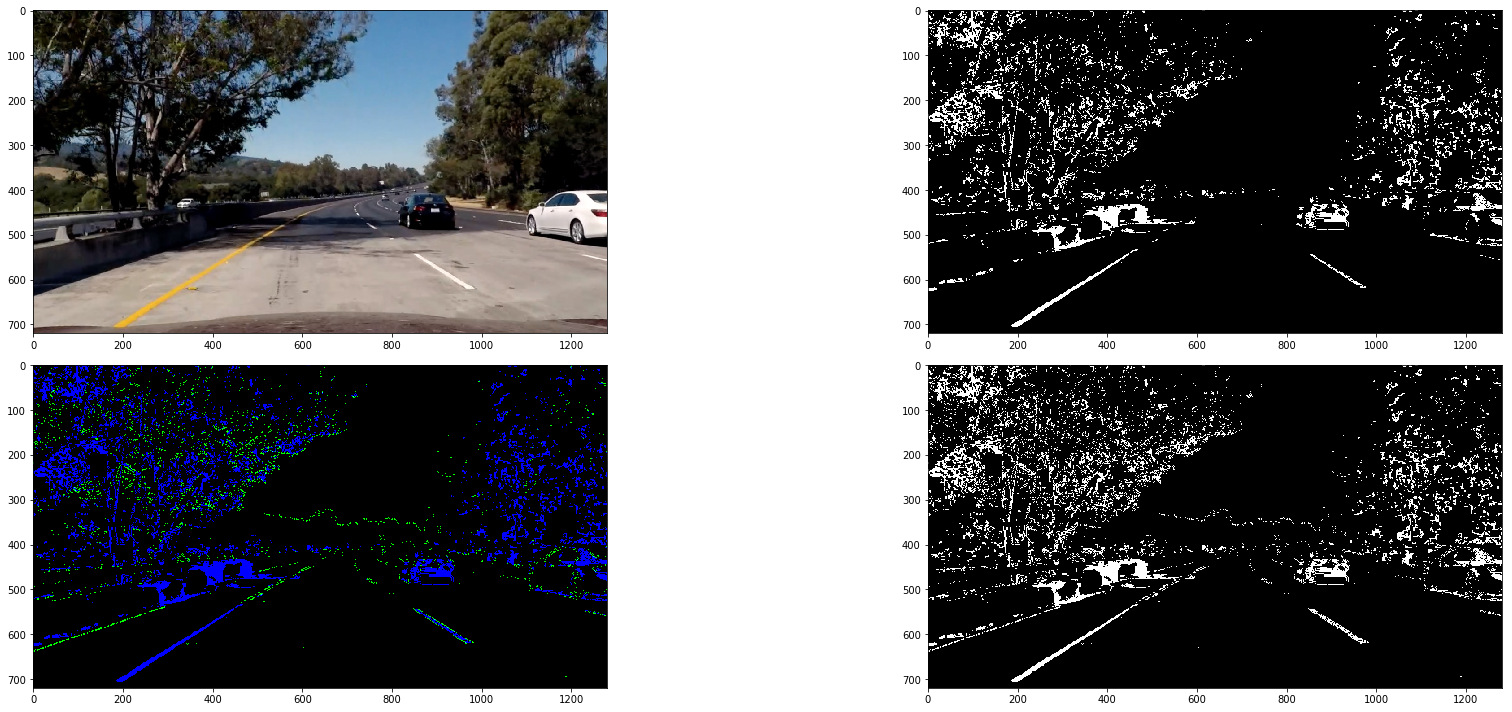

In [113]:
s_thresh=(180, 255)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS);
h_image = hls[:,:,0];
l_image = hls[:,:,1];
s_image = hls[:,:,2];

s_binary = np.zeros_like(s_image)
s_binary[(s_image>=s_thresh[0])&(s_image<=s_thresh[1])] = 1

color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary))

color_grad_thresh = np.zeros_like(combined)
color_grad_thresh[(combined==1)|(s_binary==1)] = 1 

f, ax = plt.subplots(2, 2, figsize=(25, 10));
f.tight_layout()
ax[0,0].imshow(image);
ax[0,1].imshow(s_binary, cmap='gray');
ax[1,0].imshow(color_binary);
ax[1,1].imshow(color_grad_thresh, cmap='gray');

In [125]:
print(np.pi/2)

1.5707963267948966
